This example tests whether an approach that uses empirical characteristic functions (ECFs) can detect differences in models with different parameters. 

In [1]:
from matplotlib import pyplot as plt
import ipywidgets as ipw
from IPython.display import display
import numpy as np
import pandas as pd

from stochastic_models import model_tellurium_ex
from stochastic_tests import Test
import stochastic_repro as sr

t_fin = 50.0
num_steps = 1000
test_kwargs = dict(t_fin=t_fin, 
                   num_steps=num_steps, 
                   sample_times=[t_fin / num_steps * i for i in range(0, num_steps + 1)], 
                   trials=[100, 1000, 10000])

k11_mean = 0.1
k12_mean = 0.11

test1 = Test(model=model_tellurium_ex({'k1': ('norm', (k11_mean, k11_mean / 10))}), stochastic=False, **test_kwargs)
test2 = Test(model=model_tellurium_ex({'k1': ('norm', (k12_mean, k11_mean / 10))}), stochastic=False, **test_kwargs)
tests = [test1, test2]

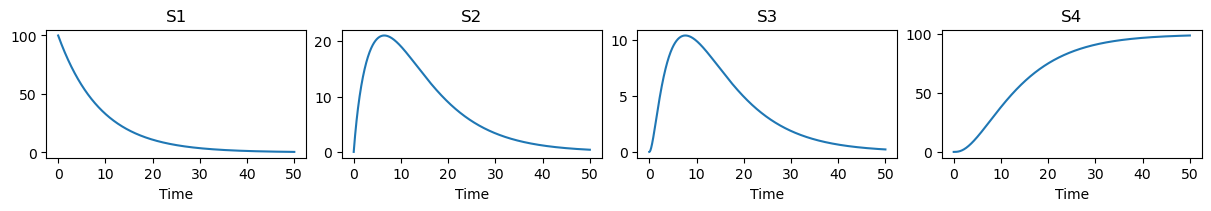

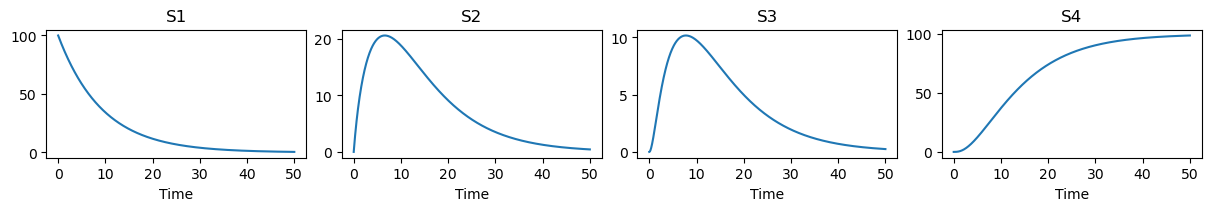

In [2]:
for test in tests:
    test.execute_deterministic()
    _ = test.plot_results_deterministic()

In [3]:
label, out = ipw.Label(), ipw.Output()
display(out)
with out:
    display(label)

for test in tests:
    test.execute_stochastic(label)
_ = out.clear_output()

Output()

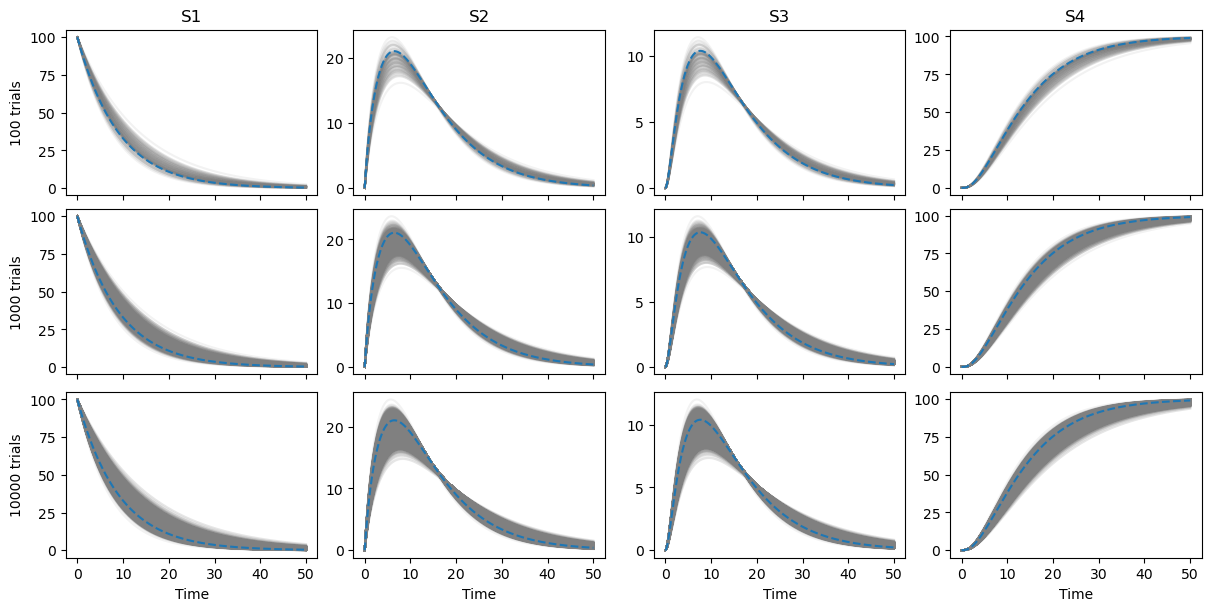

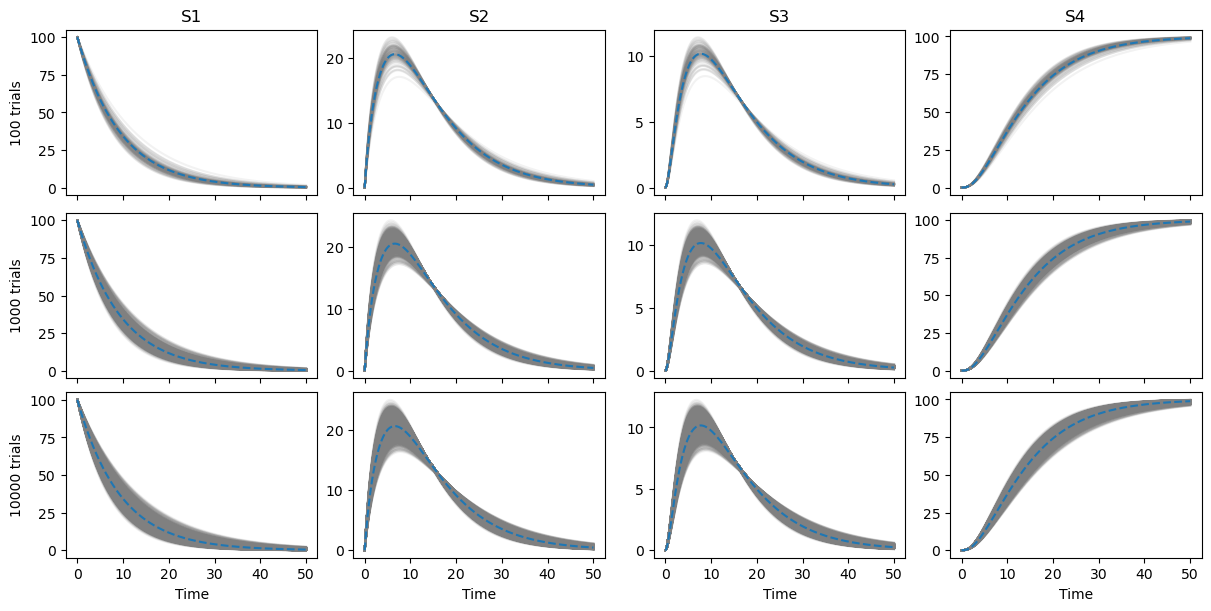

In [4]:
for test in tests:
    _ = test.plot_results_stochastic()

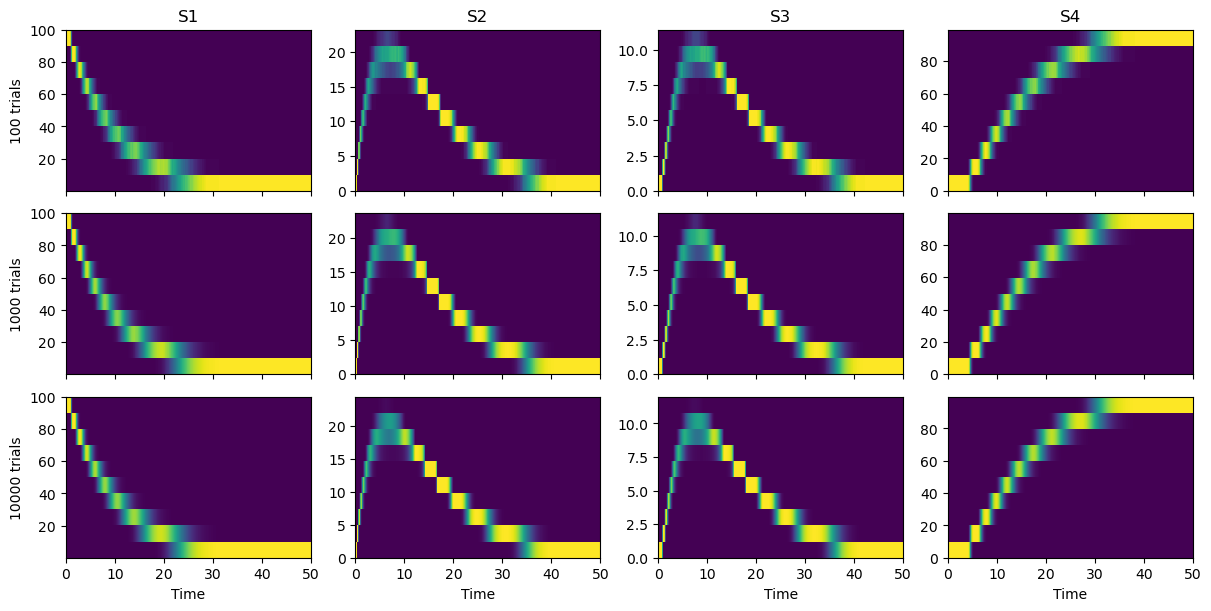

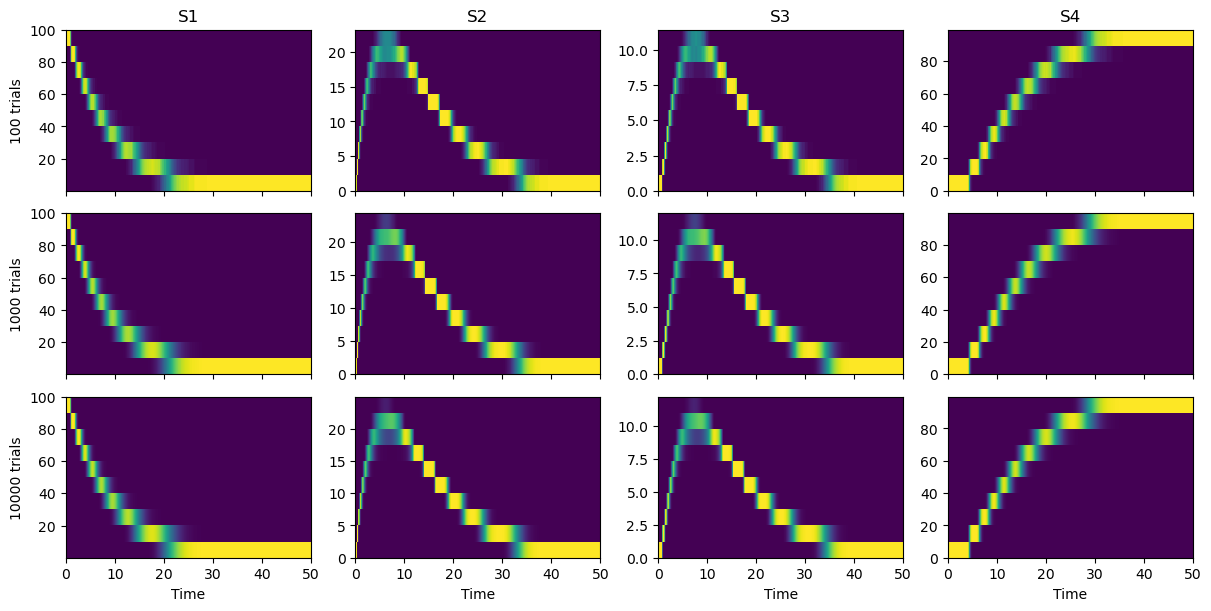

In [5]:
for test in tests:
    _ = test.plot_distributions()

Output()

/Users/timothy.sego/PycharmProjects/ssr_project_2024/code/stochastic_repro.py:992: OptimizeWarning: Covariance of the parameters could not be estimated
  return curve_fit(fit_func, data_x, data_y, **kwargs)


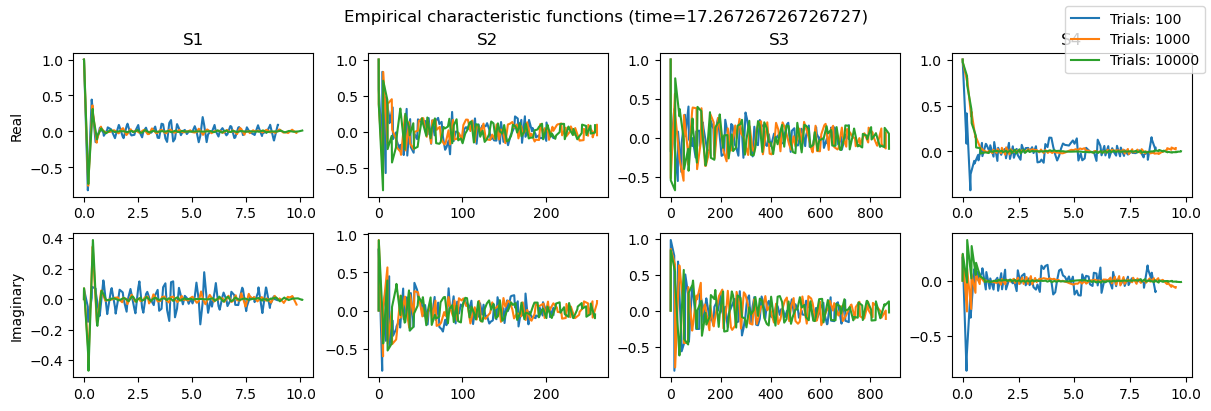

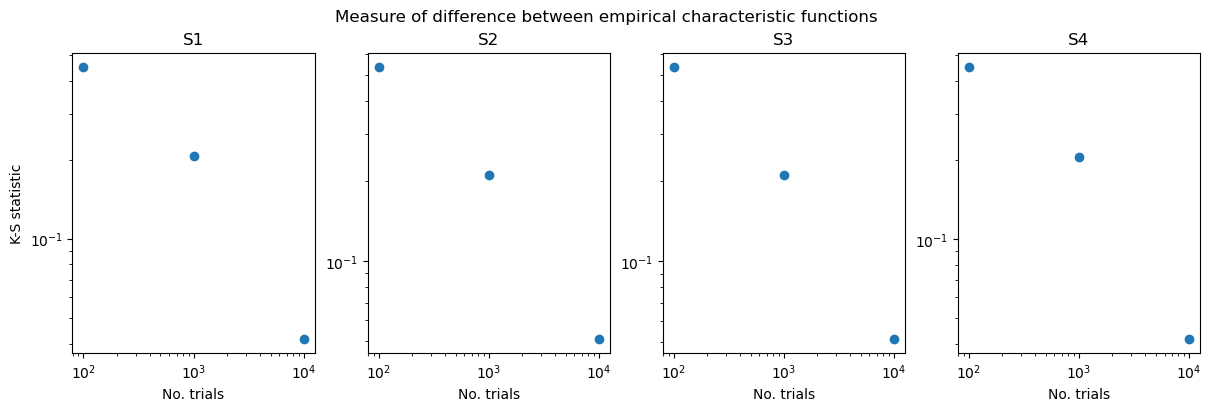

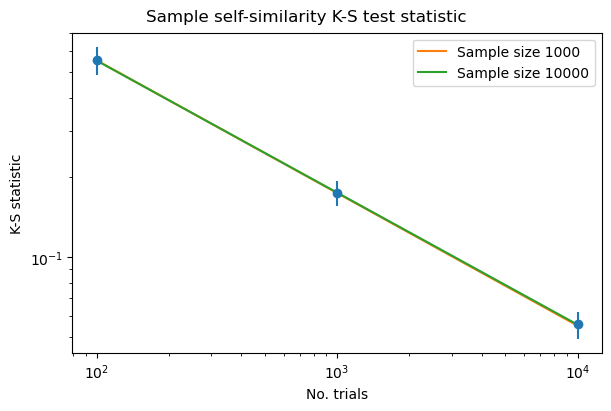

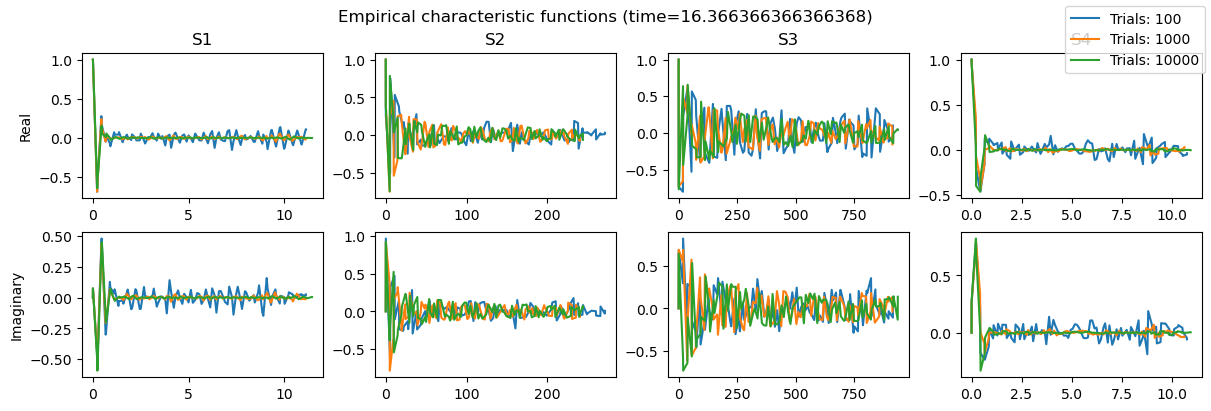

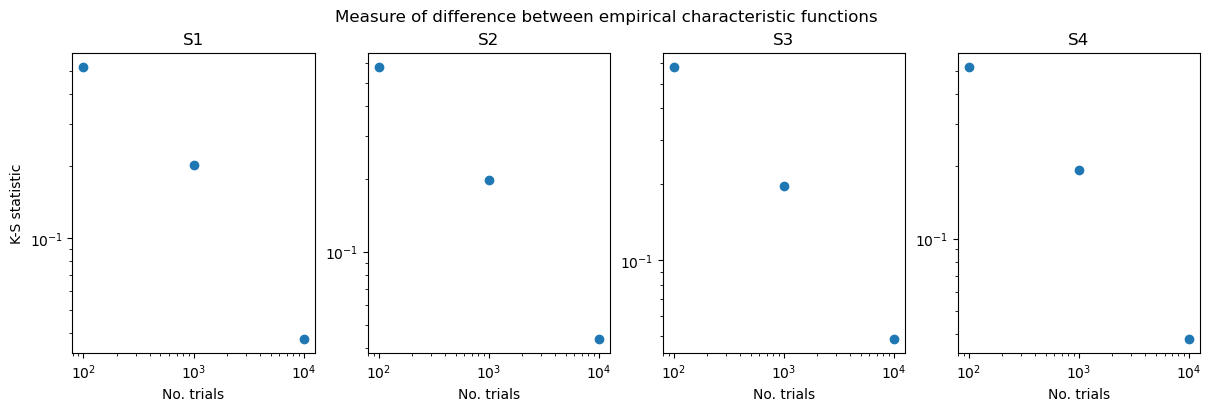

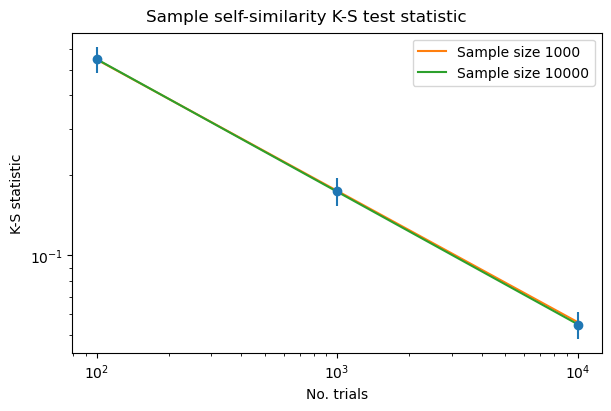

In [6]:
out = ipw.Output()
display(out)

# Runtime: ~222 minutes (M1 max)
for test in [test1, test2]:
    test.find_ecfs()
    test.measure_ecf_diffs()
    test.plot_ecf(test.max_ks_stat_time(test.trials[-1]))
    test.plot_ecf_diffs()
    with out:
        test.test_sampling(err_thresh=1E-3, quiet=False)
    test.generate_ecf_sampling_fits()
    _, ax = test.plot_ecf_sampling_fits(test.plot_ecf_sampling())
    _ = ax.legend()

Comparing the converged ECF of the two models, we should find that they are always quantifiably different since their models have different parameters.

Text(0.5, 0.98, 'Measure of empirical characteristic functions')

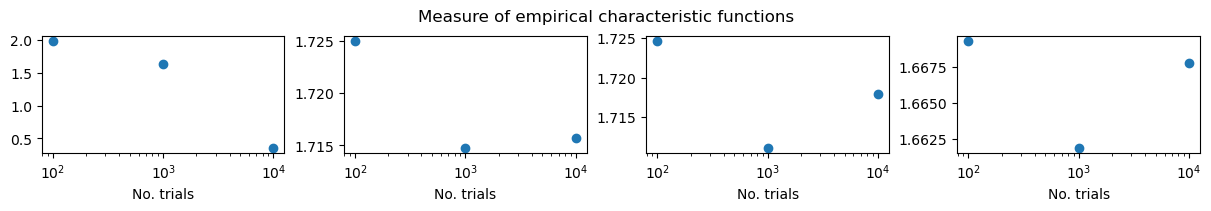

In [7]:
ecf_diff = sr.measure_ecf_diff_sets(test1.ecf, test2.ecf)

fig, ax = plt.subplots(1, len(test1.model.results_names), sharey=False, figsize=(12.0, 2.0), layout='compressed')
for i, name in enumerate(test1.model.results_names):
    ax[i].scatter(test1.trials, [max([el[name] for el in ecf_diff[trial]]) for trial in test1.trials])
    ax[i].set_xlabel('No. trials')
    ax[i].set_xscale('log')
fig.suptitle('Measure of empirical characteristic functions')

Testing for how well the method can detect differences in model parameters. 

Output()

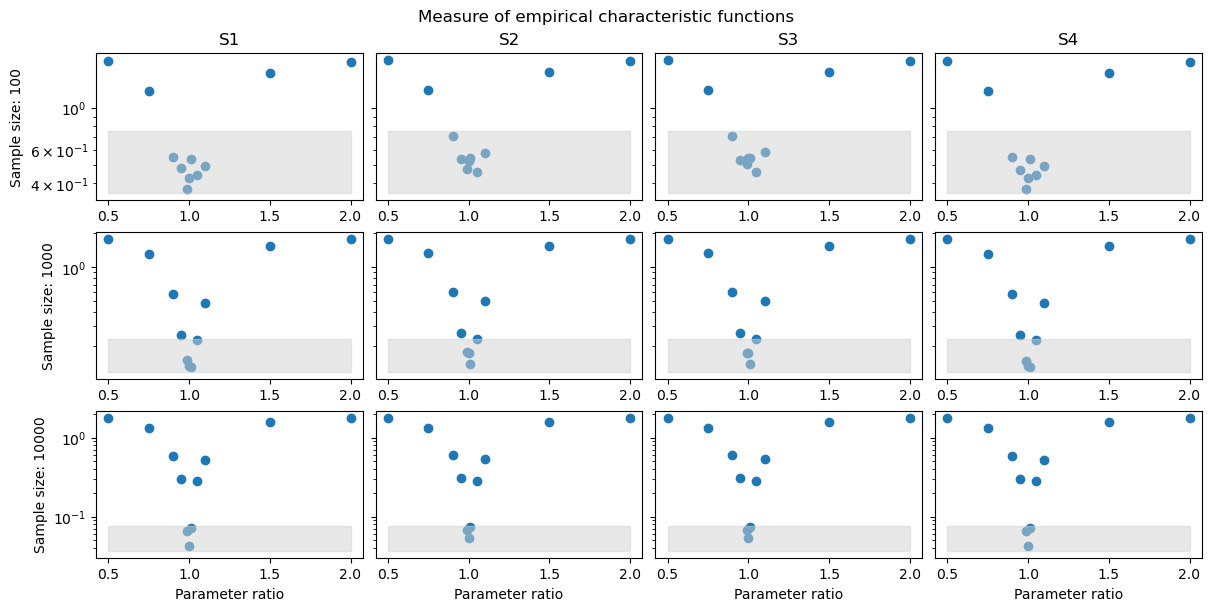

In [11]:
k1_fact = [0.5, 0.75, 0.9, 0.95, 0.99, 1.0, 1.01, 1.05, 1.1, 1.5, 2.0]
k1_comp = list()
test_test_kwargs = test_kwargs.copy()
test_test_kwargs['trials'] = [int(t / 2) for t in test_kwargs['trials']]

label, out = ipw.Label(), ipw.Output()
display(out)
with out:
    display(label)

# Make half-size tests
test1_sims_hs = {}
ecf_eval_info = {}
for trials in test1.trials:
    ht = int(trials / 2)
    simset = sr.SimSet(model=test1.model, num_trials=ht, stochastic=False, num_steps=test_kwargs['num_steps'], t_fin=test_kwargs['t_fin'])
    simset.results = {k: v[:ht, :] for k, v in test1.sims_s[trials].results.items()}
    simset.results_time = test1.sims_s[trials].results_time
    test1_sims_hs[ht] = simset
    ecf_eval_info[ht] = test1.ecf_eval_info[trials]
ecf1 = sr.generate_ecfs(test1_sims_hs, test1.sample_times, test1.model.results_names, test_test_kwargs['trials'], ecf_eval_info)

for bf in k1_fact:
    label.value = f'Factor: {bf}...'

    k1test_mean = k11_mean * bf
    test = Test(model=model_tellurium_ex({'k1': ('norm', (k1test_mean, k1test_mean / 10))}), stochastic=False, **test_test_kwargs)
    test.execute_stochastic()
    ecf2 = sr.generate_ecfs(test.sims_s, test1.sample_times, test1.model.results_names, test_test_kwargs['trials'], ecf_eval_info)
    k1_comp.append(sr.measure_ecf_diff_sets(ecf1, ecf2))

out.clear_output()

fig, ax = plt.subplots(len(test1.trials), len(test1.model.results_names), sharey='row', figsize=(12.0, 2.0 * len(test1.trials)), layout='compressed')
for i, trial in enumerate(test1.trials):
    for j, name in enumerate(test1.model.results_names):
        ax[i][j].scatter(k1_fact, [max([el[name] for el in diff[int(trial / 2)]]) for diff in k1_comp])
        
        avg = np.average(test1.ks_stats_sampling[trial])
        err = np.std(test1.ks_stats_sampling[trial]) * 3
        ax[i][j].fill_between(k1_fact, avg - err, avg + err, color='lightgray', alpha=0.5)
        ax[i][j].set_yscale('log')

for i, name in enumerate(test1.model.results_names):
    ax[0][i].set_title(name)
    ax[-1][i].set_xlabel('Parameter ratio')
for i, trial in enumerate(test1.trials):
    ax[i][0].set_ylabel(f'Sample size: {trial}')
_ = fig.suptitle('Measure of empirical characteristic functions')

In [13]:
summary_entries = ['Average', 'St. dev.']
df_summary = pd.DataFrame(index=test_kwargs['trials'], columns=summary_entries)
eval_entries = ['Sample size', 'Scaling factor', 'Error', 'Standardized error', 'Acceptance p-value']
data_eval = []

for sample_size in test_test_kwargs['trials']:
    avg = np.average(test1.ks_stats_sampling[sample_size * 2])
    std = np.std(test1.ks_stats_sampling[sample_size * 2])
    df_summary.loc[sample_size * 2, 'Average'] = avg
    df_summary.loc[sample_size * 2, 'St. dev.'] = std

    err = [max([max(d.values()) for d in diff[sample_size]]) for diff in k1_comp]
    q2 = (sample_size + 1) / sample_size * np.var(test1.ks_stats_sampling[sample_size * 2], ddof=1)
    lam2 = [(e - avg) * (e - avg) / q2 for e in err]
    pr = [np.floor((sample_size + 1) / sample_size * ((sample_size - 1) / l2 + 1)) / (sample_size + 1) for l2 in lam2]
    for i in range(len(err)):
        if pr[i] > 1.0 or err[i] < avg:
            pr[i] = 1.0

    for i, bf in enumerate(k1_fact):
        data_eval.append((sample_size * 2, bf, err[i], (err[i] - avg) / std, min(1, pr[i])))

display(df_summary)
mi_eval = pd.MultiIndex.from_frame(pd.DataFrame(data_eval, columns=eval_entries))
df_eval = mi_eval.to_frame()
display(df_eval)

,Average,St. dev.
100,0.552401,0.066242
1000,0.174723,0.019217
10000,0.055874,0.006435


Sample size  \
Sample size Scaling factor Error    Standardized error Acceptance p-value                
100         0.50           1.799986  18.833713         0.019608                    100   
            0.75           1.244498  10.447985         0.019608                    100   
            0.90           0.708275  2.353098          0.196078                    100   
            0.95           0.535450 -0.255900          1.000000                    100   
            0.99           0.502800 -0.748789          1.000000                    100   
            1.00           0.543969 -0.127292          1.000000                    100   
            1.01           0.540070 -0.186148          1.000000                    100   
            1.05           0.458685 -1.414745          1.000000                    100   
            1.10           0.584593  0.485978          1.000000                    100   
            1.50           1.553335  15.110230         0.019608                    100   
            2.00           1.771753  18.407492         0.019608                    100   
1000        0.50           1.787754  83.938877         0.001996                   1000   
            0.75           1.321272  59.664066         0.001996                   1000   
            0.90           0.600124  22.136998         0.003992                   1000   
            0.95           0.258860  4.378341          0.053892                   1000   
            0.99           0.175911  0.061817          1.000000                   1000   
            1.00           0.173069 -0.086046          1.000000                   1000   
            1.01           0.139591 -1.828196          1.000000                   1000   
            1.05           0.227964  2.770581          0.131737                   1000   
            1.10           0.499583  16.905076         0.003992                   1000   
            1.50           1.548610  71.494307         0.001996                   1000   
            2.00           1.781216  83.598657         0.001996                   1000   
10000       0.50           1.803671  271.623689        0.000200                  10000   
            0.75           1.331251  198.205284        0.000200                  10000   
            0.90           0.611692  86.379169         0.000200                  10000   
            0.95           0.312307  39.852144         0.000800                  10000   
            0.99           0.067938  1.874993          0.285543                  10000   
            1.00           0.053824 -0.318529          1.000000                  10000   
            1.01           0.074868  2.951981          0.115177                  10000   
            1.05           0.282267  35.183554         0.001000                  10000   
            1.10           0.533232  74.185783         0.000200                  10000   
            1.50           1.597278  239.548287        0.000200                  10000   
            2.00           1.797601  270.680324        0.000200                  10000   

                                                                           Scaling factor  \
Sample size Scaling factor Error    Standardized error Acceptance p-value                   
100         0.50           1.799986  18.833713         0.019608                      0.50   
            0.75           1.244498  10.447985         0.019608                      0.75   
            0.90           0.708275  2.353098          0.196078                      0.90   
            0.95           0.535450 -0.255900          1.000000                      0.95   
            0.99           0.502800 -0.748789          1.000000                      0.99   
            1.00           0.543969 -0.127292          1.000000                      1.00   
            1.01           0.540070 -0.186148          1.000000                      1.01   
            1.05           0.458685 -1.414745          1.000000                      1.